# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Do a principal components analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].  Also show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.

Notes:
* You can use `PCA` to produce a PCA analysis.

,total_variance
k,
1,0.164043
2,0.297278
3,0.399013
4,0.469646
5,0.508313
10,0.652214
20,0.808923
30,0.898488
40,0.950924


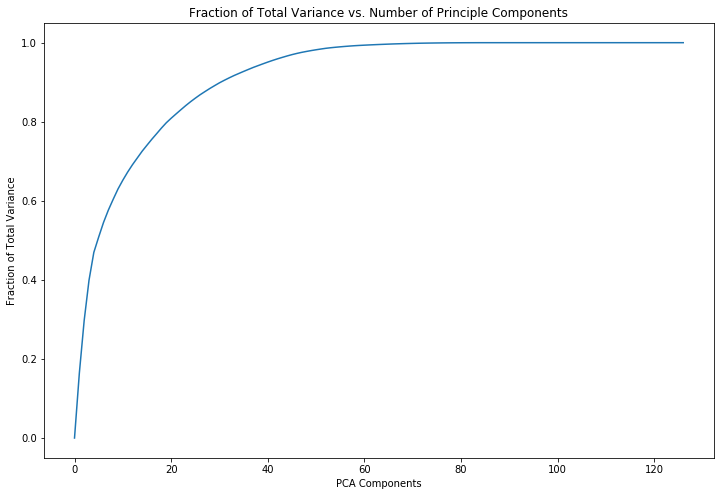

In [5]:
def P1():
  # Create pca component and varience list
  k_list, tot_var_list = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50], []

  # Iterate through pca component list
  # Calculate fraction of explained variance 
  for k in k_list:
    pca = PCA(n_components=k) # set dimensionality reduction
    pca.fit(train_data) # fit using training data
    tot_var_list.append(np.sum(pca.explained_variance_ratio_)) # append explained variance

  # Create dataframe
  df = pd.DataFrame(tot_var_list, index=k_list, columns=['total_variance'],)
  df.index.name = 'k'
  display(df)

  # Empty list for plot
  tot_var_list = []

  # Iterate through pca components and calculated explained variance
  for val in range(0, train_data.shape[1]+1):
    pca = PCA(n_components=val) # set dimensionality reduction
    pca.fit(train_data) # fit using training data
    tot_var_list.append(np.sum(pca.explained_variance_ratio_)) # append explained variance

  # Plot components vs total variance
  plt.figure(figsize=(12,8))
  plt.plot(range(0,127), tot_var_list)
  plt.title("Fraction of Total Variance vs. Number of Principle Components")
  plt.xlabel('PCA Components'), plt.ylabel('Fraction of Total Variance')
  plt.show()

P1()

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and show as a square scatterplot. Show the positive (poisonous) examples in red and the negative (non-poisonous) examples in green. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.

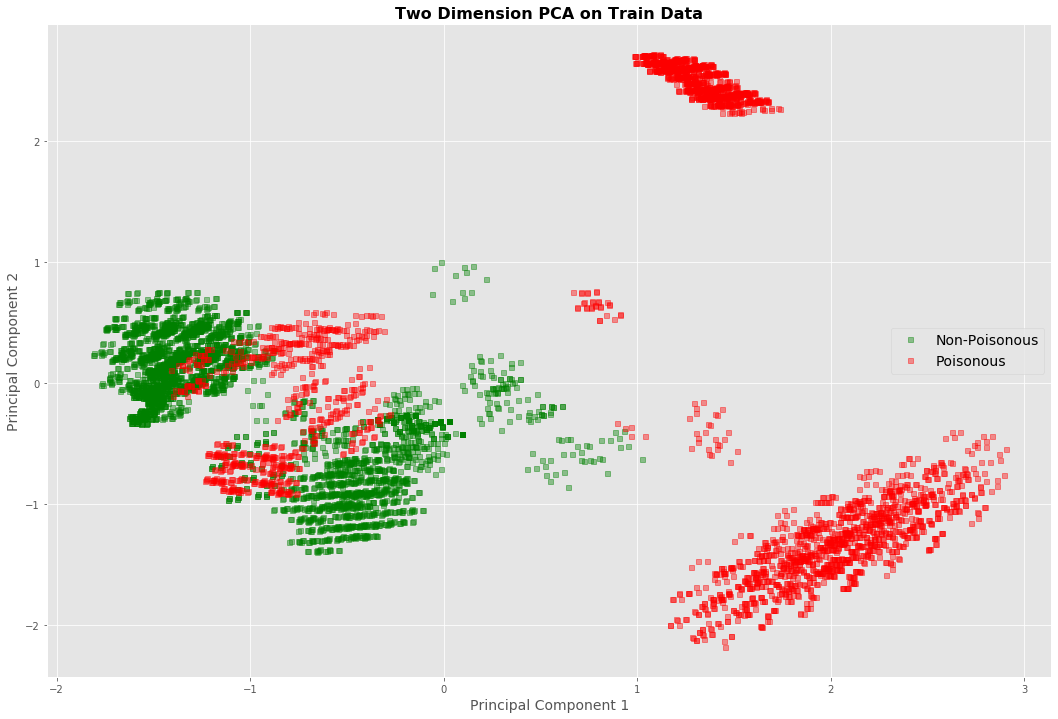

In [6]:
def P2():

  # Set dimensionality reduction to 2
  pca = PCA(n_components=2)
  fitted_values_2d = pca.fit_transform(train_data)

  plt.figure(figsize=(18,12))
  plt.style.use('ggplot')

  # Plot Component 1 vs Component 2 for Non-Poisonous mushrooms
  plt.plot(fitted_values_2d[:,0][train_labels==0], fitted_values_2d[:,1][train_labels==0], 
          'gs', alpha=0.4, markersize=5, label="Non-Poisonous")
  
  # Plot Component 1 vs Component 2 for Poisonous mushrooms
  plt.plot(fitted_values_2d[:,0][train_labels==1], fitted_values_2d[:,1][train_labels==1], 
          'rs', alpha=0.4, markersize=5, label="Poisonous")
  # Plot setup
  plt.title("Two Dimension PCA on Train Data", fontsize=16, fontweight='bold')
  plt.xlabel("Principal Component 1", fontsize=14)
  plt.ylabel("Principal Component 2", fontsize=14)
  plt.legend(loc="center right", fontsize=14)
  plt.show()

P2()

### Part 3:

Fit a k-means cluster model with 6 clusters over the 2d projected data. As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

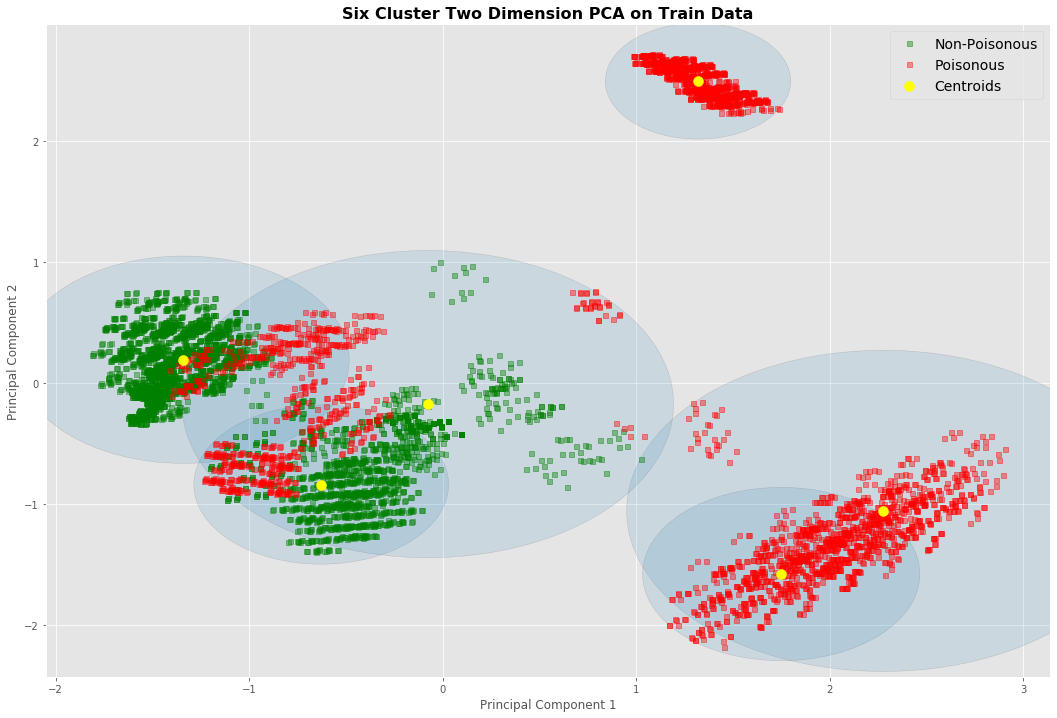

In [7]:
def P3():
  # Set dimensionality reduction to 2
  pca = PCA(n_components=2)
  pca_2d_train_data = pca.fit_transform(train_data)

  # Set KMeans to 6
  k_means = KMeans(n_clusters=6)
  k_means_clusters = k_means.fit(pca_2d_train_data)
  centroids = k_means_clusters.cluster_centers_ # get coordinates of cluster centroids
  y_kmeans = k_means_clusters.predict(pca_2d_train_data) # predict clusters

  # Dictionaries for cluster centroids and radii
  cluster_centroids, radii = dict(), dict()

  # Iterate through each cluster and calcualte the radius
  for cluster in range(6):
    cluster_centroids[cluster]=list(zip(k_means_clusters.cluster_centers_[:, 0], 
                                        k_means_clusters.cluster_centers_[:,1]))[cluster]
    radii[cluster] = max([np.linalg.norm(np.subtract(i,centroids[cluster])) \
                          for i in zip(pca_2d_train_data[y_kmeans == cluster, 0], 
                                       pca_2d_train_data[y_kmeans == cluster, 1])])

  # Plot clusters and cluster circles

  fig, ax = plt.subplots(1,figsize=(18,12))
  # Plot Component 1 vs Component 2 for Non-Poisonous mushrooms
  plt.plot(pca_2d_train_data[:,0][train_labels==0], pca_2d_train_data[:,1][train_labels==0], 
          'gs', alpha=0.4, markersize=5, label="Non-Poisonous", zorder=1)
  # Plot Component 1 vs Component 2 for Poisonous mushrooms
  plt.plot(pca_2d_train_data[:,0][train_labels==1], pca_2d_train_data[:,1][train_labels==1], 
          'rs', alpha=0.4, markersize=5, label="Poisonous", zorder=2)
  # Plot cluster centroids
  plt.scatter(centroids[:, 0], centroids[:,1], s = 100, c = 'yellow', label = 'Centroids', zorder=3)


  for i in range(6):
          art = mpatches.Circle(cluster_centroids[i], radii[i], fill='black', edgecolor='black',alpha=0.15)
          ax.add_patch(art)

  # Plot setup      
  plt.title("Six Cluster Two Dimension PCA on Train Data", fontsize=16, fontweight='bold')
  plt.xlabel('Principal Component 1'), plt.ylabel('Principal Component 2')
  plt.legend(fontsize=14)
  plt.show()

P3()

### Part 4:

Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  Show square plots of the estimated density contours presented in a 4x4 grid - one row each for a number of mixture components and one column each for a convariance matrix type.  

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

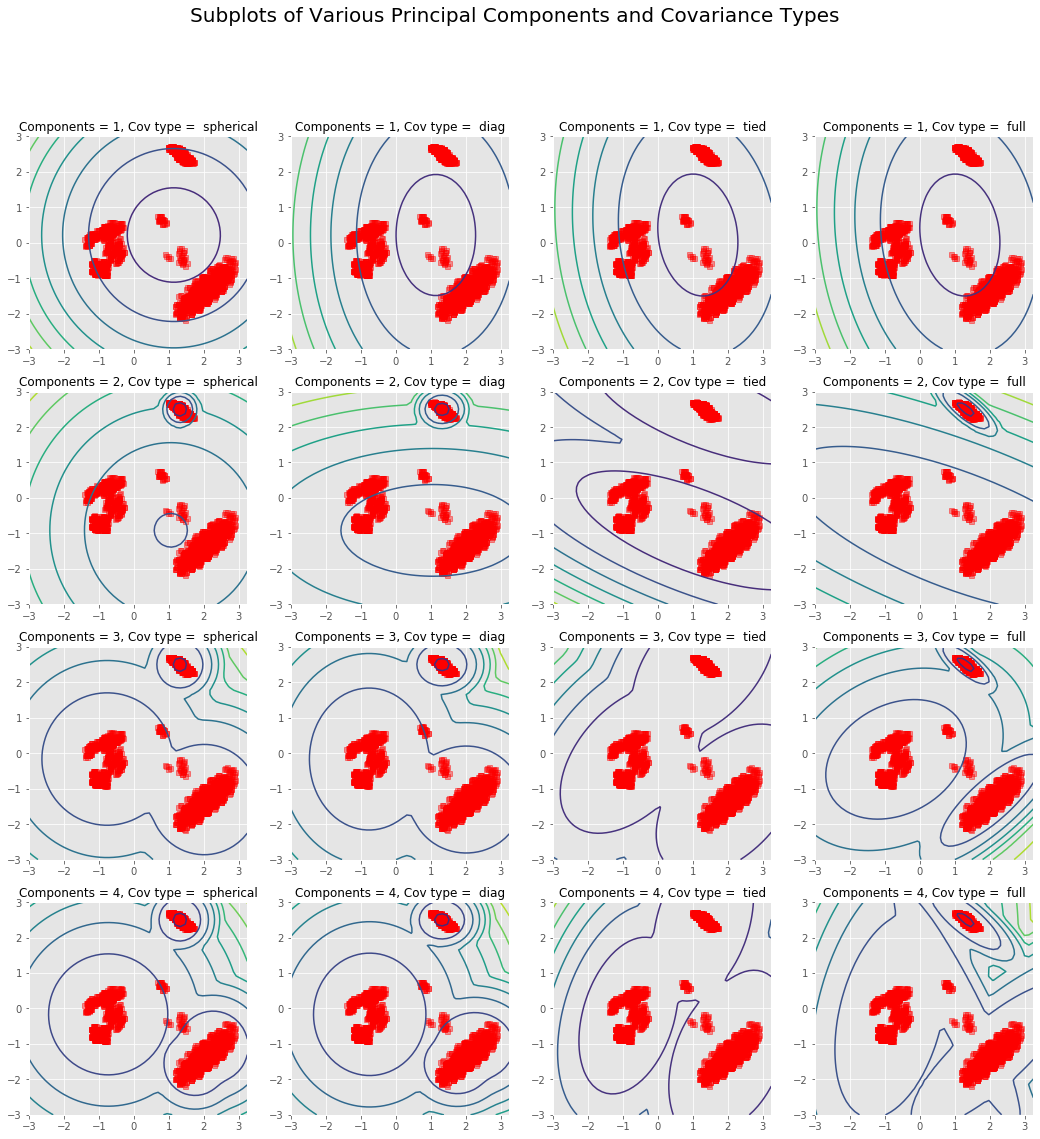

In [8]:
def P4():
  # Set dimensionality reduction to 2
  pca = PCA(n_components=2)
  pca_2d_train = pca.fit_transform(train_data) # fit train data
  pca_2d_train_pos = pca_2d_train[train_labels==1] # get posinous data

  # Plot setup
  fig, axs = plt.subplots(4,4) # 4x4 plot
  fig.set_figheight(18) # plot height
  fig.set_figwidth(18) # plot width

  cov_types = ['spherical', 'diag', 'tied', 'full']
  # Build models for each n components and type of covariance
  for n in range(1,5):
      for c in range(4):
          # Train Gaussian mixture model
          gmm = GaussianMixture(n_components=n, covariance_type=cov_types[c], random_state=12345)
          gmm.fit(pca_2d_train_pos)
          pcx, pcy = [item[0] for item in pca_2d_train_pos],  [item[1] for item in pca_2d_train_pos]
          
          # Predicted scores by the model as a contour plot
          x = np.linspace(-3, 3.25)
          y = np.linspace(-3, 3)
          X, Y = np.meshgrid(x, y)
          XX = np.array([X.ravel(), Y.ravel()]).T
          Z = -gmm.score_samples(XX)
          Z = Z.reshape(X.shape)
          
          # Plot contour results
          axs[n-1, c].plot(pcx, pcy, 'rs', alpha=0.4, markersize=5, zorder=1)
          axs[n-1, c].contour(X, Y, Z)
          axs[n-1, c].set_title("Components = {}, Cov type =  {}".format(n, cov_types[c]), fontsize=12)
         
  plt.suptitle("Subplots of Various Principal Components and Covariance Types", fontsize=20)
  plt.show()

P4()

### Part 5:

Fit two Gaussian mixture models, one for the positive examples and one for the negative examples in your 2d projected data. Use 4 mixture components and full convariance for each model.  Predict the test example labels by picking the labels corresponding to the larger of the two models' probabilities.  What is the accuracy of you predictions on the test data?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [9]:
def P5():
  # Set dimensionality reduction to 2
  pca = PCA(n_components=2)
  train_data_2d_pca = pca.fit_transform(train_data) # fit train data
  # Seperate posionous and non-posionous data
  train_data_2d_pca_pos, train_data_2d_pca_neg = train_data_2d_pca[train_labels==1], train_data_2d_pca[train_labels==0]
  test_data_2d_pca = pca.transform(test_data)

  # Gaussian Mixture model for posionous and non-posinous data
  gmm_pos = GaussianMixture(n_components=4, covariance_type='full', random_state=12345)
  gmm_neg = GaussianMixture(n_components=4, covariance_type='full', random_state=12345)
  # Fit models
  gmm_pos.fit(train_data_2d_pca_pos)
  gmm_neg.fit(train_data_2d_pca_neg)
  
  # Get posionous and non-posionous probabilities 
  prob_pos, prob_neg = np.exp(gmm_pos.score_samples(test_data_2d_pca)), np.exp(gmm_neg.score_samples(test_data_2d_pca))

  # Calculate accuracy
  predictions = prob_pos > prob_neg
  accuracy = sum(np.equal(predictions, test_labels))/len(test_labels)
  print("The accuuarcy of predictions on the test data is {:.2f}%.".format(accuracy*100))

P5()


The accuuarcy of predictions on the test data is 95.02%.


### Part 6:

Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.


* For spherical, diag, and full covariance types:
  * number of parameters = (number of parameters per gmm component * number of gmm components - 1) * number of classes
  * number of parameters per gmm component includes all the means plus all the non-zero, non-duplicated values in the covariance matrix plus the mixing weight
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter


* To calculate the number of parameters for tied covariance type:
  * number of parameters = (number of parameters per class - 1) * number of classes
  * number of parameters per class includes all the means and mixing weights for all the gmm components plus all the non-zero, non-duplicated values in the one shared covariance matrix
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter

In [10]:
def P6():
  accuracy_list, num_param_list, pca_comp_list, gm_comp_list, cov_list = [], [], [], [], []

  # set dimensionality reduction to different values
  for pca_comp in range(1,9):
    pca = PCA(n_components=pca_comp)
    train_data_pca = pca.fit_transform(train_data)
    train_data_pca_pos, train_data_pca_neg = train_data_pca[train_labels==1], train_data_pca[train_labels==0]
    test_data_pca = pca.transform(test_data)

    cov_types = ['spherical', 'diag', 'tied', 'full']

    for gm_comp in range(1,9):
      for cov in cov_types:
        # Gaussian Mixture model for posionous and non-posinous data
        gmm_pos = GaussianMixture(n_components=gm_comp, covariance_type=cov, random_state=12345)
        gmm_neg = GaussianMixture(n_components=gm_comp, covariance_type=cov, random_state=12345)
        # fit models
        gmm_pos.fit(train_data_pca_pos)
        gmm_neg.fit(train_data_pca_neg)

        # calculate number of parameters
        num_classes = 2   # poisonous / non-poisonous

        if cov == 'spherical':
          num_params = ((pca_comp*gm_comp + gm_comp) * num_classes)
        elif cov == 'diag':  
          num_params = ((pca_comp*gm_comp + pca_comp * gm_comp) * num_classes)
        elif cov == 'tied':      
          num_params = ((pca_comp*gm_comp + pca_comp * (pca_comp + 1)/ 2) * num_classes)
        elif cov ==  'full':  
          num_params = ((pca_comp*gm_comp + pca_comp * (pca_comp + 1)/ 2 * gm_comp) * num_classes)
        else:
          num_params = -1
          continue

        # if the number of parameters <= 50 then calculate accuracy and save results
        if num_params > 50:
            continue
        else:
          prob_pos, prob_neg = np.exp(gmm_pos.score_samples(test_data_pca)), np.exp(gmm_neg.score_samples(test_data_pca))
          predictions = prob_pos > prob_neg
          accuracy = sum(np.equal(predictions, test_labels))/len(test_labels)

          # append lists  with values for accuracy, parameters, pca comp., gmm comp., and covarince types
          accuracy_list.append(accuracy), num_param_list.append(num_params), pca_comp_list.append(pca_comp) 
          gm_comp_list.append(gm_comp), cov_list.append(cov)

  # create dataframe of accuracy, mix components, and covariance types
  df = pd.DataFrame({'accuracy':accuracy_list,
                    'num_parameters':num_param_list,
                    'pca_components': pca_comp_list,
                    'gm_components':gm_comp_list,
                    'covariance':cov_list})

  # display Gaussian Mixture model with the highest accuracy
  print("The Gaussian mixture model that results in the best accuracy with no more than 50 parameters is:\n")
  display(df[df.accuracy==df.accuracy.max()])

P6()

The Gaussian mixture model that results in the best accuracy with no more than 50 parameters is:



,accuracy,num_parameters,pca_components,gm_components,covariance
106,0.97331,48.0,7,3,spherical
